## Programming project: probability of death

In this project, you have to predict the probability of death of a patient that is entering an ICU (Intensive Care Unit).

The dataset comes from MIMIC project (https://mimic.physionet.org/). MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

Each row of *mimic_train.csv* correponds to one ICU stay (*hadm_id*+*icustay_id*) of one patient (*subject_id*). Column HOSPITAL_EXPIRE_FLAG is the indicator of death (=1) as a result of the current hospital stay; this is the outcome to predict in our modelling exercise.
The remaining columns correspond to vitals of each patient (when entering the ICU), plus some general characteristics (age, gender, etc.), and their explanation can be found at *mimic_patient_metadata.csv*.

Please don't use any feature that you infer you don't know the first day of a patient in an ICU.

Note that the main cause/disease of patient condition is embedded as a code at *ICD9_diagnosis* column. The meaning of this code can be found at *MIMIC_metadata_diagnose.csv*. **But** this is only the main one; a patient can have co-occurrent diseases (comorbidities). These secondary codes can be found at *extra_data/MIMIC_diagnoses.csv*.

As performance metric, you can use *AUC* for the binary classification case, but feel free to report as well any other metric if you can justify that is particularly suitable for this case.

Main tasks are:
+ Using *mimic_train.csv* file build a predictive model for *HOSPITAL_EXPIRE_FLAG* .
+ For this analysis there is an extra test dataset, *mimic_test_death.csv*. Apply your final model to this extra dataset and generate predictions following the same format as *mimic_kaggle_death_sample_submission.csv*. Once ready, you can submit to our Kaggle competition and iterate to improve the accuracy.

As a *bonus*, try different algorithms for neighbor search and for distance, and justify final selection. Try also different weights to cope with class imbalance and also to balance neighbor proximity. Try to assess somehow confidence interval of predictions.

You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset.
2. Manage missing data.
2. Manage categorial features. E.g. create *dummy variables* for relevant categorical features, or build an ad hoc distance function.
3. Build a prediction model. Try to improve it using methods to tackle class imbalance.
5. Assess expected accuracy  of previous models using *cross-validation*.
6. Test the performance on the test file and report accuracy, following same preparation steps (missing data, dummies, etc). Remember that you should be able to yield a prediction for all the rows of the test dataset.

Feel free to reduce the training dataset if you experience computational constraints.

## Main criteria for IN_CLASS grading
The weighting of these components will vary between the in-class and extended projects:
+ Code runs - 20%
+ Data preparation - 35%
+ Nearest neighbor method(s) have been used - 15%
+ Probability of death for each test patient is computed - 10%
+ Accuracy of predictions for test patients is calculated (kaggle) - 10%
+ Hyperparameter optimization - 5%
+ Class imbalance management - 5%
+ Neat and understandable code, with some titles and comments - 0%
+ Improved methods from what we discussed in class (properly explained/justified) - 0%

# 0. Import libraries and initiate workspace


In [512]:
# Basic libraries
import pandas as pd
import time
import numpy as np
from collections import Counter
from pandas_profiling import ProfileReport

# Sklearn
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler, FunctionTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer

# Imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline as imbpipeline

# Helper functions
from utils.helper_functions import plot_confusion_matrix, get_auc, log_transform
import category_encoders as ce

# Visualization
import plotly.express as px

Import train and test dataframes

In [464]:
train = pd.read_csv("/Users/gnlm/Desktop/K-Nearest-Neighbours/data/mimic_train.csv")
test = pd.read_csv("/Users/gnlm/Desktop/K-Nearest-Neighbours/data/mimic_test_death.csv")
comorbidity = pd.read_csv("/Users/gnlm/Desktop/K-Nearest-Neighbours/data/extra_data/MIMIC_diagnoses.csv")

Function for preprocessing data according to instructions
* Age feature is top censored for age > 89. Hence, I encode all such observations as 90
* Generate AGE_AT_ADMIT feature as the difference between ADMITTIME and DOB
* Drop features from drop_list as per instructions

In [465]:
# Preprocess data according to instructions:
drop_list = [ 'DOD', 'DISCHTIME', 'DEATHTIME', 'LOS', 'ADMITTIME', 'DOB']
def preproc(df):
    # Get date_of_birth and quarter of day of admission
    df['AGE_AT_ADMIT'] = pd.to_datetime(df['ADMITTIME']).dt.year - pd.to_datetime(df['DOB']).dt.year
    # Note that individuals older than 89 are encoded as 300, so I just enter 90 in these observations
    df['AGE_AT_ADMIT'] = df['AGE_AT_ADMIT'].apply(lambda x: 90 if x > 89 else x)
    df['QUART_DAY'] = np.ceil(pd.to_datetime(df['ADMITTIME']).dt.hour/6).astype("category")

    # Drop variables as per instructions
    for item in drop_list:
        if item in df.columns:
            df = df.drop(item, axis = 1)
        else:
            pass
    return df

Preprocess train and test sets:

In [466]:
train = preproc(train)
test = preproc(test)
# Check shapes of dfs:
print(f"Shape of training dataset: {train.shape} \n Shape of test dataset: {test.shape}")

Shape of training dataset: (20885, 40) 
 Shape of test dataset: (5221, 39)


# 1. EDA

Many variables are correlated.
Diagnosis and ICD9 diagnosis have high cardinality

In [467]:
profile = ProfileReport(train, explorative=True, dark_mode=True)
profile.to_file('profile_report.html')

## 1.1 Missing Data

Missing observations are consistent across train and test datasets. If a variable has missing observations in train, it aslo has similar proportion of missing in test.

In [468]:
percent_missing_train = train.isnull().sum() * 100 / len(train)
percent_missing_test = test.isnull().sum() * 100 / len(test)
missing_value_df = pd.DataFrame({
                                 'data_type':train.dtypes,
                                 'percent_missing_train': percent_missing_train,
                                      'percent_missing_test':percent_missing_test})
missing_value_df

,data_type,percent_missing_train,percent_missing_test
ADMISSION_TYPE,object,0.000000,0.000000
AGE_AT_ADMIT,int64,0.000000,0.000000
DIAGNOSIS,object,0.000000,0.000000
DiasBP_Max,float64,10.576969,10.572687
DiasBP_Mean,float64,10.576969,10.572687
DiasBP_Min,float64,10.576969,10.572687
Diff,float64,0.000000,0.000000
ETHNICITY,object,0.000000,0.000000
FIRST_CAREUNIT,object,0.000000,0.000000
GENDER,object,0.000000,0.000000


## 1.2 Class Balance
Data is not severely imbalanced

In [469]:
print(Counter(train.HOSPITAL_EXPIRE_FLAG))
print(f"Class-balance in train data = {len(train[train.HOSPITAL_EXPIRE_FLAG == 1]) *100 / len(train)} %")

Counter({0: 18540, 1: 2345})
Class-balance in train data = 11.228154177639453 %


## 1.3 Feature Engineering

### Incorporate comorbidities into the data set

ICD9 diagnosis and diagnosis features contain valuable information regarding the patient. However, cardinality of both features is extremely high. Dummifying the features would blow up the feature space and increase computation time drastically. Hence, I target encode them using the target feature to creat a 'mortality proxy' for each ICD9 code by combining the comorbidity data with the HOSPITAL_EXPIRE_FLAG. Furthermore, I add the mean and max probability of dying associated with the comorbidities for each patient.
* First, the first 3 characters of ICD9 codes relate to the broad category of the disease. Hence, I use it to reduce dimensionlaity.
* Second, I create 3 proxies for mortality. First is the mean mortality rate for each ICD9 disease from the whole training set: mortality_proxy. Second, is the mean mortality of the ICD9_diagnoses for each patient: max_mortality. Last is the maximum mortality for each patient: mean_mortality

In [471]:
# Reduce string length of diagnoses:
for df in [train, test]:
    df['ICD9_diagnosis'] = df['ICD9_diagnosis'].str[:3]
    df['ICD9_diagnosis'] = df['ICD9_diagnosis'].astype("str")
comorbidity['ICD9_CODE'] = comorbidity['ICD9_CODE'].str[:3]
# Convert comorbiidty df columns to lowercase
comorbidity = comorbidity.rename(columns=str.lower)
# Drop na's as there is no way to infer these data
comorbidity = comorbidity.dropna()
# Merge HOSPITAL_EXPIRE_FLAG to comorbidity dataset
comorbidity = pd.merge(left=comorbidity,
                       right=train[['subject_id', 'hadm_id', 'HOSPITAL_EXPIRE_FLAG']],
                       how='left',
                       on=['subject_id', 'hadm_id'])

# Construct the mortality proxy for each ICD9 code
mortality_proxy = comorbidity.groupby('icd9_code')['HOSPITAL_EXPIRE_FLAG'].mean().reset_index()
mortality_proxy = mortality_proxy.rename(columns={'HOSPITAL_EXPIRE_FLAG': 'mortality_proxy', 'icd9_code': 'ICD9_diagnosis'})

# For each patient, compute mean and max probability of dying associated with the comorbidities
comorbidity['mortality_proxy'] = comorbidity['HOSPITAL_EXPIRE_FLAG'].groupby(comorbidity['icd9_code']).transform('mean')
comorbidity['max_mortality'] = comorbidity['mortality_proxy'].groupby(comorbidity['subject_id']).transform('max')
comorbidity['mean_mortality'] = comorbidity['mortality_proxy'].groupby(comorbidity['subject_id']).transform('mean')

# Drop duplicate records
comorbidity = comorbidity.drop_duplicates(subset=['subject_id', 'hadm_id'])

# Merge variables proxying the mortality associated with each ICD9 code back to train and test
train = pd.merge(left=train,
                right=comorbidity[['subject_id', 'hadm_id', 'max_mortality', 'mean_mortality', 'mortality_proxy']],
                how='left', on=['subject_id', 'hadm_id'])

test = pd.merge(left=test,
                right=comorbidity[['subject_id', 'hadm_id', 'max_mortality', 'mean_mortality', 'mortality_proxy']],
                how='left', on=['subject_id', 'hadm_id'])

## 1.3 Create target and feature dfs

In [472]:
# Create target feature
y = train['HOSPITAL_EXPIRE_FLAG']
# Drop ID variables and ICD9 and Diff since we have age
X = train.drop(['HOSPITAL_EXPIRE_FLAG', 'subject_id', 'hadm_id', 'icustay_id', 'Diff'], axis = 1)
# Gender has mixed-type data, convert a
print(f"Shape of training dataset: {X.shape} \n Shape of test dataset: {y.shape}")

Shape of training dataset: (20885, 38) 
 Shape of test dataset: (20885,)


Here, I isolate ICD9_diagnosis from the categorical features to use a binary encoder on the feature.

In [473]:
cat_features = X.select_dtypes(include = ['object', 'category']).columns
# isolate ICD9_diagnosis from categorical features
cat_features = cat_features.drop('ICD9_diagnosis')
icd9_feature = ['ICD9_diagnosis']
num_features = X.select_dtypes(include = [np.number]).columns

# Check that I have captured all features:
print(f"All features captured from cat_features and num_features: {len(cat_features) + len(num_features) + len(icd9_feature) == len(X.columns)}")

All features captured from cat_features and num_features: True


# 2. TRAINING A KNN CLASSIFIER:

## 2.1 Simple Model
Not accounting for class imbalance here
* Additional mortality features generated from the comorbiidty datasets are encoded using the target feature. This is highly likely to overfit and produce a perfect classifier. I first run a simple model without these additional features to gauge the general performance of a model.
* Start with k = sqrt(len(train)) as an initial value.

In [522]:
# Drop generated mortality features
mortality_features = ['max_mortality', 'mean_mortality', 'mortality_proxy']
X_simple = X.drop(mortality_features, axis = 1)
test_simple = test.drop(mortality_features, axis = 1)

# Get data types:
cat_features_simple = X_simple.select_dtypes(include = ['object', 'category']).columns
# isolate ICD9_diagnosis from categorical features
cat_features_simple = cat_features_simple.drop('ICD9_diagnosis')
icd9_feature = ['ICD9_diagnosis']
num_features_simple = X_simple.select_dtypes(include = [np.number]).columns

# Check that I have captured all features:
print(f"All features captured from cat_features and num_features: {len(cat_features_simple) + len(num_features_simple) + len(icd9_feature) == len(X_simple.columns)}")

# Initial value for K
initial_n = round(np.sqrt(len(train)))
print(f"Starting value for KNN Classifier: {initial_n}")

All features captured from cat_features and num_features: True


145

In [ ]:
log_tranformer = FunctionTransformer(log_transform)

numeric_transformer = Pipeline(
             steps = [("imputer", SimpleImputer(strategy = "mean")),
                      ("log", log_tranformer),
                     ("scaler", StandardScaler())])

categorical_transformer = Pipeline(
             steps = [ ("imputer", SimpleImputer(strategy = "most_frequent")),
                        ( "ohe", OneHotEncoder(handle_unknown='ignore', sparse=False))])

icd9_transformer = Pipeline(
    steps=[ ("enocder", ce.BinaryEncoder())]
)

# preprocessor pipeline combining both:
preprocessor = ColumnTransformer(transformers=[
        ("num", numeric_transformer, num_features_simple),
        ("cat", categorical_transformer, cat_features_simple),
        ("icd9", icd9_transformer, icd9_feature)])

# Define the pipeline for preprocessing and the classifier.
clf_simple = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', KNeighborsClassifier(n_neighbors = initial_n,
                                                          n_jobs = -1))])

# Check structure of pipeline:
clf_simple

## 2.1.1 In-Sample Performance: Simple Model

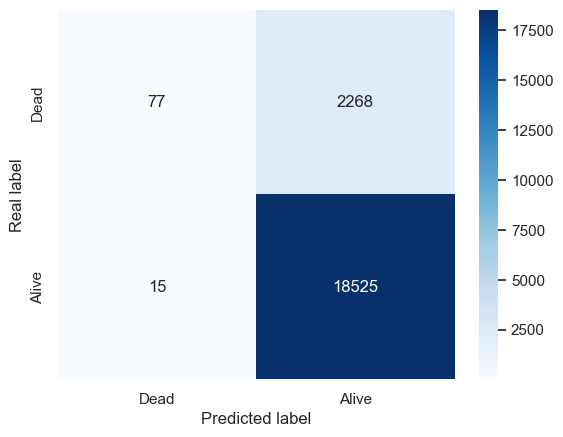

Accuracy :  0.8906870960019152
ROC_AUC :  0.8065789292097073
AUC:  0.8065789292097073


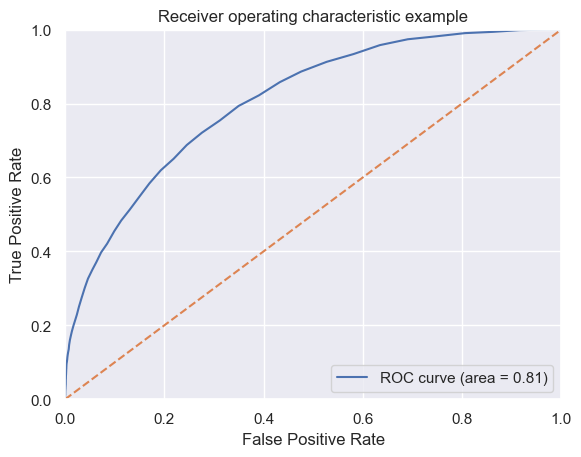

In [527]:
# Fit the model
clf_simple.fit(X_simple, y)

# Get in-sample point and probability fitted values
y_hat_in_simple = clf_simple.predict(X_simple)
y_hat_in_proba_simple = clf_simple.predict_proba(X_simple)
# Confusion Matrix
class_labels = ["Dead","Alive"]
cm =  confusion_matrix(y_pred=y_hat_in_simple, y_true=y, labels=[1,0])
# Plotting confusion matrix
plot_confusion_matrix(cm, class_labels)
# ROC_AUC
print("Accuracy : ", accuracy_score(y,y_hat_in_simple))
print("ROC_AUC : ", roc_auc_score(y, y_hat_in_proba_simple[:,1]))
class_labels = ["0","1"]
get_auc(y, y_hat_in_proba_simple, class_labels, plot=True)

## 2.1.2 Grid Search With Simple Model

In [ ]:
param_grid = {#'classifier__n_neighbors': [135, 145, 155], # 135 chosen
              'classifier__n_neighbors': [115, 125, 135]
              # 'classifier__n_neighbors': [100, 200, 300, 400, 500],
              # 'classifier__weights': ['uniform', 'distance']
              # 'classifier__p': [1, 2] All models choose p = 2, so I abandon this parameter search
              }
# Initiate grid search object
grid_search = GridSearchCV(clf_simple,
                           param_grid,
                           cv=3,
                           scoring = "recall", # I use recall as I consider predicting death to be more important and minimize false negatives
                           verbose = 10)
# Fit the grid search
grid_search.fit(X_simple, y)

# Get best parameters
print(grid_search.best_params_) # K = 115

# Get in-sample point and probability fitted values
y_hat_in_simple_cv = grid_search.predict(X)
y_hat_in_proba_simple_cv = grid_search.predict_proba(X)

## 2.1.3 In-Sample Performance: Simple model with CV

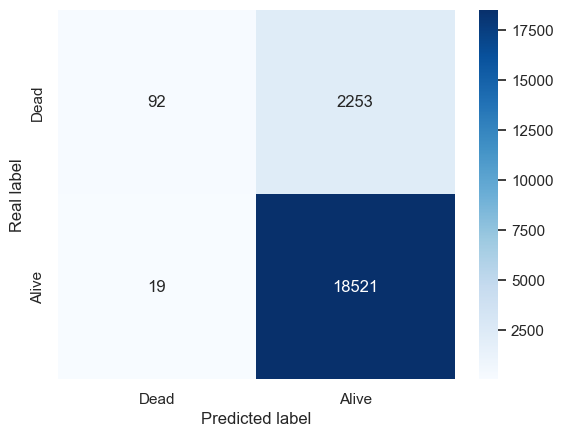

Accuracy :  0.8912137898012928
ROC_AUC :  0.8113158663455722
AUC:  0.8113158663455722


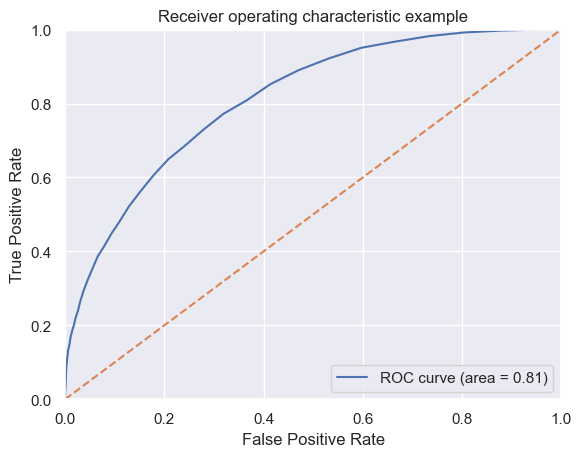

In [531]:
# Confusion Matrix
class_labels = ["Dead","Alive"]
cm =  confusion_matrix(y_pred=y_hat_in_simple_cv, y_true=y, labels=[1,0])
# Plotting confusion matrix
plot_confusion_matrix(cm, class_labels)
# ROC_AUC
print("Accuracy : ", accuracy_score(y,y_hat_in_simple_cv))
print("ROC_AUC : ", roc_auc_score(y, y_hat_in_proba_simple_cv[:,1]))
class_labels = ["0","1"]
get_auc(y, y_hat_in_proba_simple_cv, class_labels, plot=True)

## 2.1.4 Test-sample Performance: Simple CV
### Kaggle Score: 0.81063

In [532]:
# Predict on test set:
# Get features of training set
simple_features = X_simple.columns
y_hat_test_proba = grid_search.predict_proba(test[simple_features])

# Copy test dataset
test_predictions_submit = pd.DataFrame({"icustay_id": test["icustay_id"], "HOSPITAL_EXPIRE_FLAG": y_hat_test_proba[:,1]})

# Convert to csv
test_predictions_submit.to_csv("knn_simple_cv", index = False)

## 2.2 Model with comorbidity data:

In [533]:
log_tranformer = FunctionTransformer(log_transform)

numeric_transformer = Pipeline(
             steps = [("imputer", SimpleImputer(strategy = "mean")),
                      ("log", log_tranformer),
                     ("scaler", StandardScaler())])

categorical_transformer = Pipeline(
             steps = [ ("imputer", SimpleImputer(strategy = "most_frequent")),
                        ( "ohe", OneHotEncoder(handle_unknown='ignore', sparse=False))])

icd9_transformer = Pipeline(
    steps=[ ("enocder", ce.BinaryEncoder())]
)

# preprocessor pipeline combining both:
preprocessor = ColumnTransformer(transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
        ("icd9", icd9_transformer, icd9_feature)])

# Define the pipeline for preprocessing and the classifier.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', KNeighborsClassifier(n_neighbors = initial_n,
                                                            n_jobs = -1))])

# Check structure of pipeline:
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('log',
                                                                   FunctionTransformer(func=<function log_transform at 0x13e2c1f70>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       '...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'DIAGNOSIS', 'FIRST_CAREUNIT', 'QUART_DAY'],
      dtype='object')),
                                                 ('icd9',
                                                  Pipeline(steps=[('enocder',
                                                                   BinaryEncoder())]),
                                                  ['ICD9_diagnosis'])])),
                ('classifier',
                 KNeighborsClassifier(n_jobs=-1, n_neighbors=145))])

## 2.2.1 Fit model with K = inital_n and check in-sample performance

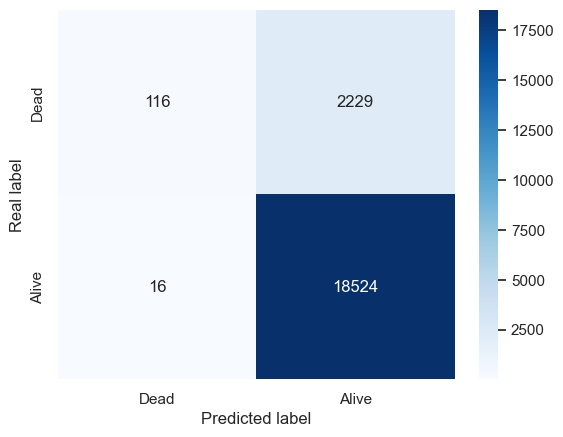

Accuracy :  0.8925065836724922
ROC_AUC :  0.890178384545143
AUC:  0.890178384545143


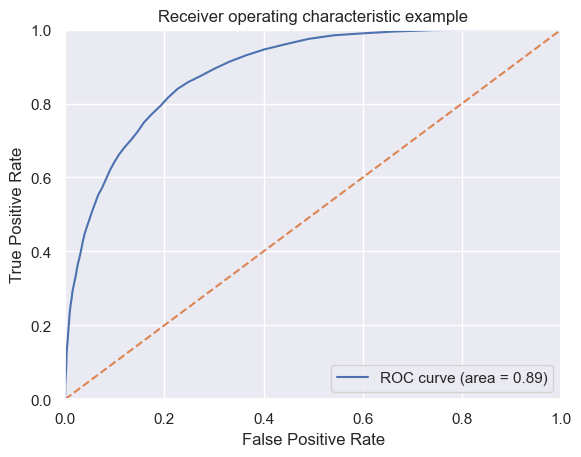

In [536]:
# Fit the model
clf.fit(X, y)

# Get in-sample point and probability fitted values
y_hat_in = clf.predict(X)
y_hat_in_proba = clf.predict_proba(X)

# Confusion Matrix
class_labels = ["Dead","Alive"]
cm =  confusion_matrix(y_pred=y_hat_in, y_true=y, labels=[1,0])
# Plotting confusion matrix
plot_confusion_matrix(cm, class_labels)
# ROC_AUC
print("Accuracy : ", accuracy_score(y,y_hat_in))
print("ROC_AUC : ", roc_auc_score(y, y_hat_in_proba[:,1]))
class_labels = ["0","1"]
get_auc(y, y_hat_in_proba, class_labels, plot=True)

## 2.2.2 GridSearch

In [ ]:
# Try different parameter grids if extreme values are chose.
param_grid = {#'classifier__n_neighbors': [140, 150, 160]}
              'classifier__n_neighbors': [100, 150, 200],
              # 'classifier__n_neighbors': [100, 200, 300, 400, 500],
              'classifier__weights': ['uniform', 'distance']
              # 'classifier__p': [1, 2] All models choose p = 2, so I abandon this parameter search
              }

# Initiate grid search object
grid_search = GridSearchCV(clf,
                           param_grid,
                           cv=5,
                           scoring = "recall", # I use recall as I consider predicting death to be more important and minimize false negatives
                           verbose = 10)
# Fit the grid search
grid_search.fit(X, y)

# Get best parameters
print(grid_search.best_params_) # K = 100

# Get in-sample point and probability fitted values
y_hat_in_cv = grid_search.predict(X)
y_hat_in_proba_cv = grid_search.predict_proba(X)

# 2.2.3 In-Sample Performance: Comorbidity Model With CV
The model achieves a perfect score in classification. Possible that the model is over-fitting.

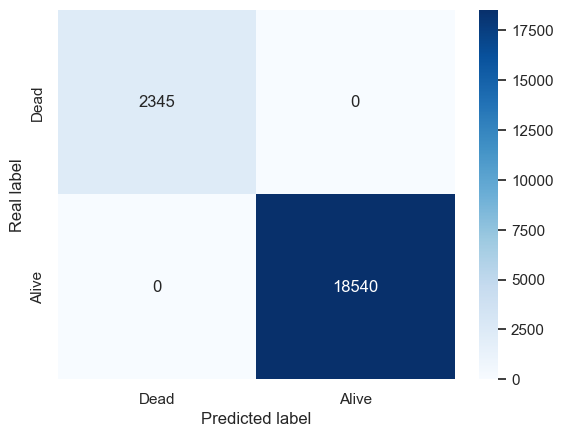

Accuracy :  1.0
ROC_AUC :  1.0
AUC:  1.0


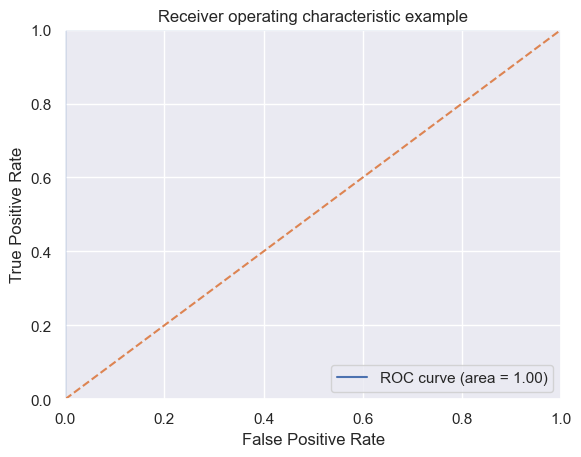

In [538]:
# Confusion Matrix
class_labels = ["Dead","Alive"]
cm =  confusion_matrix(y_pred=y_hat_in_cv, y_true=y, labels=[1,0])
# Plotting confusion matrix
plot_confusion_matrix(cm, class_labels)
# ROC_AUC
print("Accuracy : ", accuracy_score(y,y_hat_in_cv))
print("ROC_AUC : ", roc_auc_score(y, y_hat_in_proba_cv[:,1]))
class_labels = ["0","1"]
get_auc(y, y_hat_in_proba_cv, class_labels, plot=True)

## Test-Sample Performance: Comorb CV
### Kaggle score from the above model is 0.87828.

In [539]:
# Predict on test set:
# Get features of training set
features = X.columns
y_hat_test_proba = grid_search.predict_proba(test[features])

# Copy test dataset
test_predictions_submit = pd.DataFrame({"icustay_id": test["icustay_id"], "HOSPITAL_EXPIRE_FLAG": y_hat_test_proba[:,1]})

# Convert to csv
test_predictions_submit.to_csv("knn_simple_comorb_cv", index = False)

## 2.3 Improved model using SMOTE Tomek:
In this section, I tackle the issue of class imbalance by using SMOTE and SMOTE-Tomek techniques and incorporate it into the pipeline.

In [504]:
param_grid = {'classifier__n_neighbors': [100, 200, 300, 400, 500],
              'classifier__weights': ['uniform', 'distance']
              # 'classifier__p': [1, 2] All models choose p = 2, so I abandon this parameter search
              }
pipeline_smoteT = imbpipeline(steps = [('preproc', preprocessor),
                                      ('smoteT', TomekLinks(sampling_strategy = 'majority')),
                                      ('classifier', KNeighborsClassifier(n_jobs = -1))])

pipeline_smoteT

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('log',
                                                                   FunctionTransformer(func=<function log_transform at 0x13e2c1f70>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanB...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'DIAGNOSIS', 'FIRST_CAREUNIT', 'QUART_DAY'],
      dtype='object')),
                                                 ('icd9',
                                                  Pipeline(steps=[('enocder',
                                                                   BinaryEncoder())]),
                                                  ['ICD9_diagnosis'])])),
                ('smoteT', TomekLinks(sampling_strategy='majority')),
                ('classifier', KNeighborsClassifier(n_jobs=-1))])

In [ ]:
start_time = time.time()
# Initiate grid search object
grid_search_smoteT = GridSearchCV(pipeline_smoteT,
                           param_grid,
                           cv=5,
                           scoring = "recall", # Use recall as predicting death is more important
                           verbose = 10)
# Fit the grid search
grid_search_smoteT.fit(X, y)

# Get best parameters
print(grid_search_smoteT.best_params_) # K = 100

# Get in-sample point and probability fitted values
y_hat_in_smoteT = grid_search_smoteT.predict(X)
y_hat_in_proba_smoteT = grid_search_smoteT.predict_proba(X)

print("--- %s seconds ---" % (time.time() - start_time))

# 2.3.1 In-Sample Model Performance
The model again achieves a perfect score in classification. Possible that the model is over-fitting.

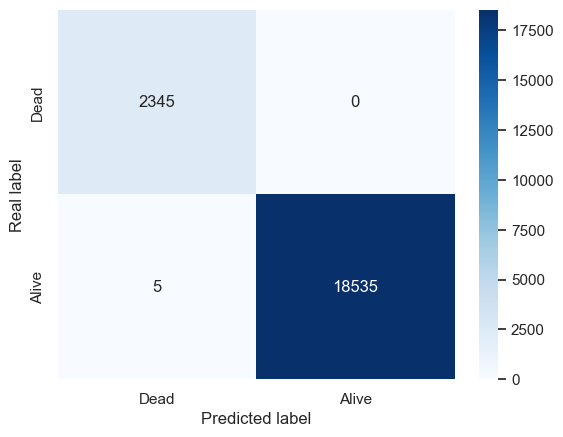

Accuracy :  0.9997605937275557
ROC_AUC :  1.0
AUC:  1.0


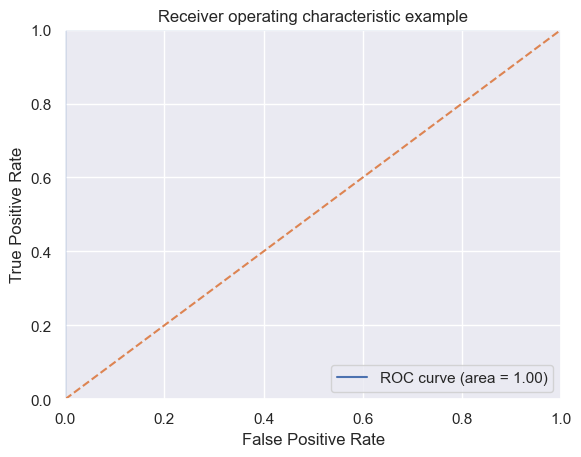

In [511]:
# Confusion Matrix
class_labels = ["Dead","Alive"]
cm =  confusion_matrix(y_pred=y_hat_in_smoteT, y_true=y, labels=[1,0])
# Plotting confusion matrix
plot_confusion_matrix(cm, class_labels)
# ROC_AUC
print("Accuracy : ", accuracy_score(y,y_hat_in_smoteT))
print("ROC_AUC : ", roc_auc_score(y, y_hat_in_proba_smoteT[:,1]))
class_labels = ["0","1"]
get_auc(y, y_hat_in_proba_smoteT, class_labels, plot=True)

## 2.3.2 Test-Sample Performance
## Kaggle score for SMOTE Tomek model is 0.88

In [508]:
# Predict on test set:
# Get features of training set
features = X.columns
y_hat_test_proba = grid_search_smoteT.predict_proba(test[features])

# Copy test dataset
test_predictions_submit_smoteT = pd.DataFrame({"icustay_id": test["icustay_id"], "HOSPITAL_EXPIRE_FLAG": y_hat_test_proba[:,1]})

# Convert to csv
test_predictions_submit_smoteT.to_csv("knn_smoteT", index = False)

## 2.4 SMOTE

In [514]:
param_grid = {'classifier__n_neighbors': [100, 200, 300, 400, 500], # 200 chosen
              'classifier__weights': ['uniform', 'distance']
              # 'classifier__p': [1, 2] All models choose p = 2, so I abandon this parameter search
              }
pipeline_smote = imbpipeline(steps = [('preproc', preprocessor),
                                      ('smote', SMOTE(random_state = 11)),
                                      ('classifier', KNeighborsClassifier(n_jobs = -1))])

pipeline_smote

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('log',
                                                                   FunctionTransformer(func=<function log_transform at 0x13e2c1f70>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanB...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'DIAGNOSIS', 'FIRST_CAREUNIT', 'QUART_DAY'],
      dtype='object')),
                                                 ('icd9',
                                                  Pipeline(steps=[('enocder',
                                                                   BinaryEncoder())]),
                                                  ['ICD9_diagnosis'])])),
                ('smote', SMOTE(random_state=11)),
                ('classifier', KNeighborsClassifier(n_jobs=-1))])

In [540]:
start_time = time.time()
# Initiate grid search object
grid_search_smote = GridSearchCV(pipeline_smote,
                           param_grid,
                           cv=5,
                           scoring = "recall", # Use recall as predicting death is more important
                           verbose = 10)
# Fit the grid search
grid_search_smote.fit(X, y)

# Get best parameters
print(grid_search_smote.best_params_) # K = 200

# Get in-sample point and probability fitted values
y_hat_in_smote = grid_search_smote.predict(X)
y_hat_in_proba_smote = grid_search_smote.predict_proba(X)

print("--- %s seconds ---" % (time.time() - start_time))

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3; 1/6] START classifier__n_neighbors=100, classifier__weights=uniform....
[CV 1/3; 1/6] END classifier__n_neighbors=100, classifier__weights=uniform;, score=0.927 total time=  31.1s
[CV 2/3; 1/6] START classifier__n_neighbors=100, classifier__weights=uniform....
[CV 2/3; 1/6] END classifier__n_neighbors=100, classifier__weights=uniform;, score=0.927 total time=  31.1s
[CV 3/3; 1/6] START classifier__n_neighbors=100, classifier__weights=uniform....
[CV 3/3; 1/6] END classifier__n_neighbors=100, classifier__weights=uniform;, score=0.927 total time=  26.9s
[CV 1/3; 2/6] START classifier__n_neighbors=100, classifier__weights=distance...
[CV 1/3; 2/6] END classifier__n_neighbors=100, classifier__weights=distance;, score=0.927 total time=  23.8s
[CV 2/3; 2/6] START classifier__n_neighbors=100, classifier__weights=distance...
[CV 2/3; 2/6] END classifier__n_neighbors=100, classifier__weights=distance;, score=0.930 total time= 

# 2.4.1 In-Sample Model Performance
The model again achieves a perfect score in classification. Possible that the model is over-fitting.

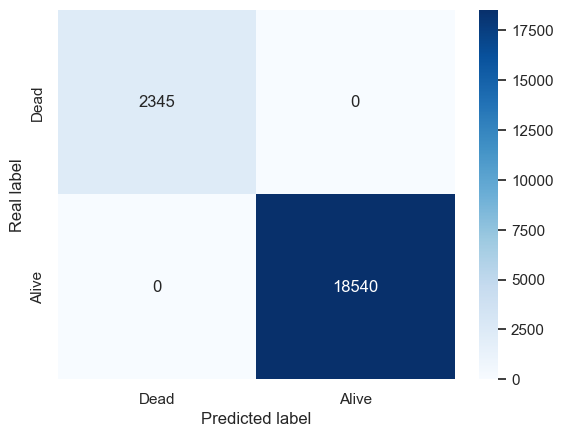

Accuracy :  1.0
ROC_AUC :  1.0
AUC:  1.0


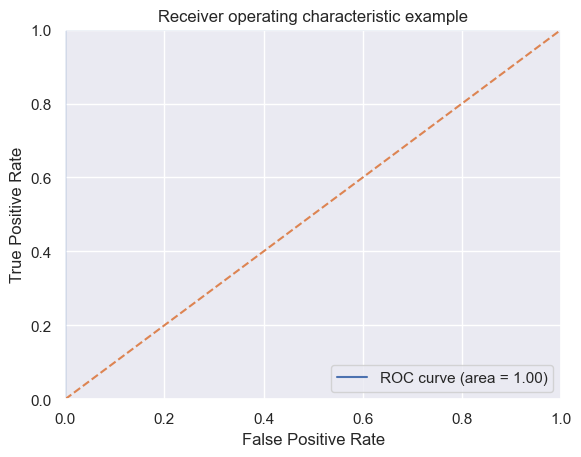

In [541]:
# Confusion Matrix
class_labels = ["Dead","Alive"]
cm =  confusion_matrix(y_pred=y_hat_in_smote, y_true=y, labels=[1,0])
# Plotting confusion matrix
plot_confusion_matrix(cm, class_labels)
# ROC_AUC
print("Accuracy : ", accuracy_score(y,y_hat_in_smote))
print("ROC_AUC : ", roc_auc_score(y, y_hat_in_proba_smote[:,1]))
class_labels = ["0","1"]
get_auc(y, y_hat_in_proba_smote, class_labels, plot=True)

## 2.4.2 Test-Sample Performance
## Kaggle score for SMOTE model is 0.87


In [ ]:
# Predict on test set:
# Get features of training set
features = X.columns
y_hat_test_proba = grid_search_smote.predict_proba(test[features])

# Copy test dataset
test_predictions_submit_smote = pd.DataFrame({"icustay_id": test["icustay_id"], "HOSPITAL_EXPIRE_FLAG": y_hat_test_proba[:,1]})

# Convert to csv
test_predictions_submit_smote.to_csv("knn_smote", index = False)

## 2.5 Additional Model: Handling Overfitting
All models are overfitting to the training data. I try to overcome this by dropping some categorical features. I hypothesize that some features are not useful for calssification and drop these.
* ETHNICITY, RELIGION, INSURANCE, MARITAL_STATUS & GENDER are potentially not useful for classification and I drop these.

In [561]:
drop_feats = ['ETHNICITY', 'RELIGION', 'INSURANCE', 'MARITAL_STATUS', 'GENDER', 'max_mortality', 'mean_mortality']
X_low = X.drop(drop_feats, axis = 1)
# Get data types:
cat_features_low = X_low.select_dtypes(include = ['object', 'category']).columns
# isolate ICD9_diagnosis from categorical features
cat_features_low = cat_features_low.drop('ICD9_diagnosis')
icd9_feature = ['ICD9_diagnosis']
num_features_low = X_low.select_dtypes(include = [np.number]).columns

# Check that I have captured all features:
print(f"All features captured from cat_features and num_features: {len(cat_features_low) + len(num_features_low) + len(icd9_feature) == len(X_low.columns)}")

All features captured from cat_features and num_features: True


In [562]:
# preprocessor pipeline combining both:
preprocessor = ColumnTransformer(transformers=[
        ("num", numeric_transformer, num_features_low),
        ("cat", categorical_transformer, cat_features_low),
        ("icd9", icd9_transformer, icd9_feature)])

# Check structure of pipeline:
pipeline_smoteT_low = imbpipeline(steps = [('preproc', preprocessor),
                                      ('smoteT', TomekLinks(sampling_strategy = 'majority')),
                                      ('classifier', KNeighborsClassifier(n_jobs = -1))])
pipeline_smoteT_low

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('log',
                                                                   FunctionTransformer(func=<function log_transform at 0x13e2c1f70>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanB...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['ADMISSION_TYPE', 'DIAGNOSIS', 'FIRST_CAREUNIT', 'QUART_DAY'], dtype='object')),
                                                 ('icd9',
                                                  Pipeline(steps=[('enocder',
                                                                   BinaryEncoder())]),
                                                  ['ICD9_diagnosis'])])),
                ('smoteT', TomekLinks(sampling_strategy='majority')),
                ('classifier', KNeighborsClassifier(n_jobs=-1))])

Gridsearch CV

In [563]:
start_time = time.time()
# Initiate grid search object
grid_search_smoteT_low = GridSearchCV(pipeline_smoteT_low,
                           param_grid,
                           cv=3,
                           scoring = "recall", # Use recall as predicting death is more important
                           verbose = 10)
# Fit the grid search
grid_search_smoteT_low.fit(X_low, y)

# Get best parameters
print(grid_search_smoteT_low.best_params_)

# Get in-sample point and probability fitted values
y_hat_in_smoteT_low = grid_search_smoteT_low.predict(X_low)
y_hat_in_proba_smoteT_low = grid_search_smoteT_low.predict_proba(X_low)

print("--- %s seconds ---" % (time.time() - start_time))

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3; 1/6] START classifier__n_neighbors=100, classifier__weights=uniform....
[CV 1/3; 1/6] END classifier__n_neighbors=100, classifier__weights=uniform;, score=0.027 total time=  37.4s
[CV 2/3; 1/6] START classifier__n_neighbors=100, classifier__weights=uniform....
[CV 2/3; 1/6] END classifier__n_neighbors=100, classifier__weights=uniform;, score=0.028 total time=  33.5s
[CV 3/3; 1/6] START classifier__n_neighbors=100, classifier__weights=uniform....
[CV 3/3; 1/6] END classifier__n_neighbors=100, classifier__weights=uniform;, score=0.045 total time=  33.7s
[CV 1/3; 2/6] START classifier__n_neighbors=100, classifier__weights=distance...
[CV 1/3; 2/6] END classifier__n_neighbors=100, classifier__weights=distance;, score=0.028 total time=  33.3s
[CV 2/3; 2/6] START classifier__n_neighbors=100, classifier__weights=distance...
[CV 2/3; 2/6] END classifier__n_neighbors=100, classifier__weights=distance;, score=0.032 total time= 

# 2.5.1 In-Sample Model Performance
The model again achieves a perfect score in classification. Possible that the model is over-fitting.

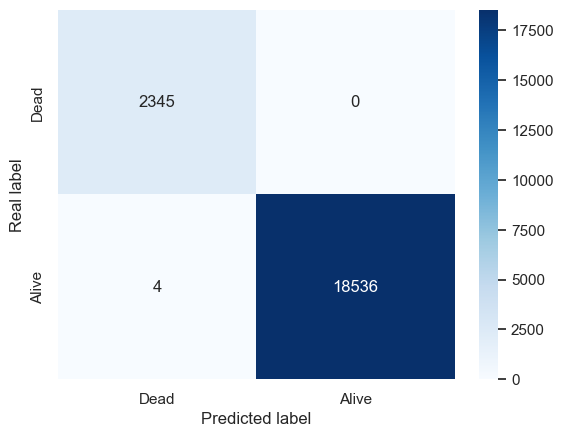

Accuracy :  0.9998084749820445
ROC_AUC :  1.0
AUC:  1.0


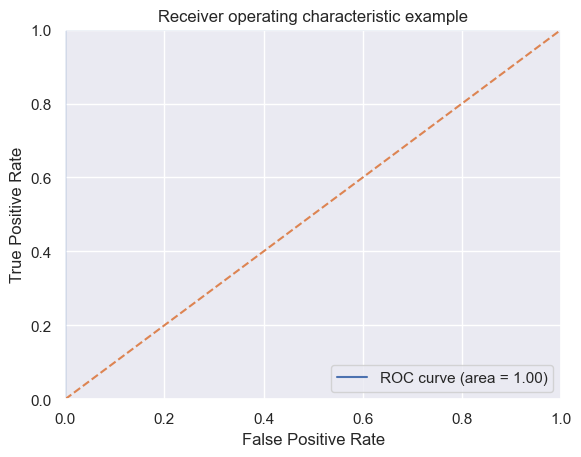

In [564]:
# Confusion Matrix
class_labels = ["Dead","Alive"]
cm =  confusion_matrix(y_pred=y_hat_in_smoteT_low, y_true=y, labels=[1,0])
# Plotting confusion matrix
plot_confusion_matrix(cm, class_labels)
# ROC_AUC
print("Accuracy : ", accuracy_score(y,y_hat_in_smoteT_low))
print("ROC_AUC : ", roc_auc_score(y, y_hat_in_proba_smoteT_low[:,1]))
class_labels = ["0","1"]
get_auc(y, y_hat_in_proba_smoteT_low, class_labels, plot=True)

## 2.5.2 Test-Sample Performance
## Kaggle score for this model is 0.82


In [565]:
# Predict on test set:
# Get features of training set
features = X.columns
y_hat_test_proba = grid_search_smoteT_low.predict_proba(test[X_low.columns])

# Copy test dataset
test_predictions_submit_smoteT = pd.DataFrame({"icustay_id": test["icustay_id"], "HOSPITAL_EXPIRE_FLAG": y_hat_test_proba[:,1]})

# Convert to csv
test_predictions_submit_smoteT.to_csv("knn_smoteT_low", index = False)

## 2.6 Remove Correlated Features
* I check for highly correlated features. First, I drop missing observations and then generate the correlation matrix from which I isolate features that have correlation coefficient greter than 0.8.

In [571]:
# Drop missing observations
X_low_corr = X.dropna(axis = 0)

# Declare empty list to store features
correlated_features = []

# Get correlation matrix
correlation_matrix = X_low_corr.corr()

# Loop through correlation matrix and add columns with correlation higher than 0.8
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            feat_name = correlation_matrix.columns[i]
            correlated_features.append(feat_name)

# Use set to get unique elements
correlated_features = list(set(correlated_features))

print(correlated_features)

['Glucose_Mean', 'TempC_Mean', 'MeanBP_Mean', 'HeartRate_Mean']


Get numerical and categorical columns

In [574]:
X_low_corr = X.drop(correlated_features, axis = 1)
# Get data types:
cat_features_low_corr = X_low_corr.select_dtypes(include = ['object', 'category']).columns
# isolate ICD9_diagnosis from categorical features
cat_features_low_corr = cat_features_low_corr.drop('ICD9_diagnosis')
icd9_feature = ['ICD9_diagnosis']
num_features_low_corr = X_low_corr.select_dtypes(include = [np.number]).columns

# Check that I have captured all features:
print(f"All features captured from cat_features and num_features: {len(cat_features_low_corr) + len(num_features_low_corr) + len(icd9_feature) == len(X_low_corr.columns)}")

All features captured from cat_features and num_features: True


Define pipeline

In [583]:
# preprocessor pipeline combining both:
preprocessor = ColumnTransformer(transformers=[
        ("num", numeric_transformer, num_features_low_corr),
        ("cat", categorical_transformer, cat_features_low_corr),
        ("icd9", icd9_transformer, icd9_feature)])

# Define the pipeline for preprocessing and the classifier.
pipeline_smoteT_corr = imbpipeline(steps = [('preproc', preprocessor),
                                      ('smoteT', TomekLinks(sampling_strategy = 'not majority')),
                                      ('classifier', KNeighborsClassifier(n_jobs = -1))])

# Check structure of pipeline:
pipeline_smoteT_corr

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('log',
                                                                   FunctionTransformer(func=<function log_transform at 0x13e2c1f70>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['HeartRate_Min', 'HeartRate_Max', 'SysBP_Min', 'SysBP_Max',
       'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min',
       'MeanBP_Ma...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'DIAGNOSIS', 'FIRST_CAREUNIT', 'QUART_DAY'],
      dtype='object')),
                                                 ('icd9',
                                                  Pipeline(steps=[('enocder',
                                                                   BinaryEncoder())]),
                                                  ['ICD9_diagnosis'])])),
                ('smoteT', TomekLinks(sampling_strategy='not majority')),
                ('classifier', KNeighborsClassifier(n_jobs=-1))])

GridsearchCV

In [ ]:
start_time = time.time()
# Initiate grid search object
gridsearch_smoteT_corr = GridSearchCV(pipeline_smoteT_corr,
                           param_grid,
                           cv=3,
                           scoring = "recall", # Use recall as predicting death is more important
                           verbose = 10)
# Fit the grid search
gridsearch_smoteT_corr.fit(X_low_corr, y)

# Get best parameters
print(gridsearch_smoteT_corr.best_params_) # K = 100

# Get in-sample point and probability fitted values
y_hat_in_smoteT_corr = gridsearch_smoteT_corr.predict(X_low_corr)
y_hat_in_proba_smoteT_corr = gridsearch_smoteT_corr.predict_proba(X_low_corr)

print("--- %s seconds ---" % (time.time() - start_time))

## 2.6.1 In-Sample Performance

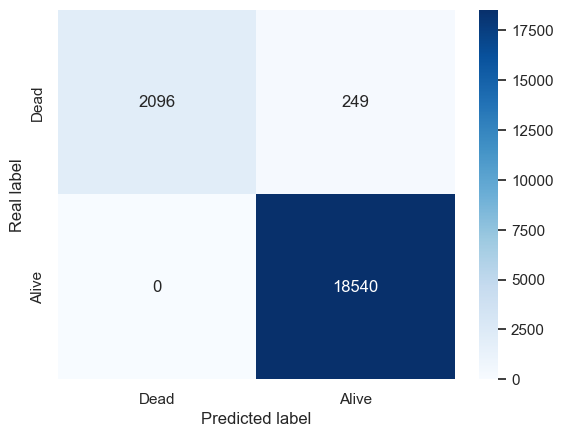

Accuracy :  0.988077567632272
ROC_AUC :  0.9982979117358193
AUC:  0.9982979117358193


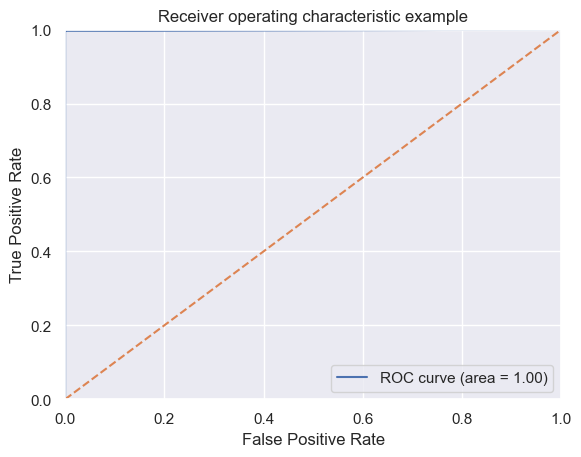

In [585]:
# Confusion Matrix
class_labels = ["Dead","Alive"]
cm =  confusion_matrix(y_pred=y_hat_in_smoteT_corr, y_true=y, labels=[1,0])
# Plotting confusion matrix
plot_confusion_matrix(cm, class_labels)
# ROC_AUC
print("Accuracy : ", accuracy_score(y,y_hat_in_smoteT_corr))
print("ROC_AUC : ", roc_auc_score(y, y_hat_in_proba_smoteT_corr[:,1]))
class_labels = ["0","1"]
get_auc(y, y_hat_in_proba_smoteT_corr, class_labels, plot=True)

## 2.6.2 Test-Sample Performance
## Kaggle score is 0.81


In [587]:
# Predict on test set:
# Get features of training set
y_hat_test_proba = gridsearch_smoteT_corr.predict_proba(test[X_low_corr.columns])

# Copy test dataset
test_predictions_submit_smoteT_corr = pd.DataFrame(
    {"icustay_id": test["icustay_id"], "HOSPITAL_EXPIRE_FLAG": y_hat_test_proba[:, 1]})

# Convert to csv
test_predictions_submit_smoteT.to_csv("knn_smoteT_low_corr", index=False)

# 3. Conclusion

The KNN classifier is overfitting to the training data. Not using certain features and discarding high-correlation features does not seem to overcome this issue. A simple model without including comorbidities achieves an accuracy of 0.89 and this goes to 1 once comorbidities are included.
In this case, Gridsearch for optimal value of K is not feasible as the in-sample accuracy is perfect once comorbidities are included. Since KNN is a lazy learning algorithm, it is extremely time inefficient to widen the parameter search. Hence, the KNN classifier might not be the best model for this dataset.